In [1]:
## Creates pointclouds and vectorizations of persistence diagrams from the ModelNet dataset.
import sys
import pickle

#import pandas as pd
from copy import deepcopy
import numpy as np
import gudhi as gd
import argparse
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import trimesh as trm
import glob


import tensorflow as tf
import tensorflow.keras as keras

from utils import DenseRagged, PermopRagged
from utils import sep_dist, measure_dist
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances

from tensorflow.keras.regularizers import l1, l2
import mtd
import numpy as np
from scipy.stats import entropy

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec


import seaborn as sns

from sklearn.decomposition import PCA



# sns.set_theme(style="darkgrid")
FIG_SIZE = (18,5)
sns.set_context("talk")
plt.style.use('ggplot')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from scipy.stats import entropy

def sym_KL(y_true, y_pred):
    loss = tf.keras.losses.KLDivergence()
    return (loss(y_true, y_pred) + loss(y_pred, y_true))/2

---
### 3D shapes

In [27]:
N_points = 1024
num_samples=1024

In [5]:
with open('Data/cross_ripsnet_3d_exp/3d_shapes_pc_train_2500_30_boostrap', 'rb') as fp:
    pc_train = pickle.load(fp)

with open("Data/cross_ripsnet_3d_exp/3d_shapes_indexes_2500_30_boostrap", "rb") as fp:
    train_indexes = pickle.load(fp)

with open('Data/cross_ripsnet_3d_exp/3d_shapes_pds_2500_30_boostrap', 'rb') as fp:
    train_PD = pickle.load(fp)

train_PD_1 = [[x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

with open("Data/cross_ripsnet_3d_exp/3d_shapes_PI_2500_30_boostrap", 'rb') as fp:   #Pickling
    PI_train_all = pickle.load(fp)

PI_train = np.vstack([PI_train_all[:2200]])
clean_PI_test = np.vstack([PI_train_all[2200:]])

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                                            patience=100, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=True)

dropout_rate = 0.2
optim = tf.keras.optimizers.Adamax(learning_rate=1e-4)
inputs_1 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)
inputs_dist = tf.keras.Input(shape=(N_points, 60), dtype ="float32", ragged=False)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)

d = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_dist)
d = DenseRagged(units=20, use_bias=True, activation='relu')(d)
d = DenseRagged(units=10, use_bias=True, activation='relu')(d)
d = PermopRagged()(d)


z = keras.layers.Concatenate(axis=-1)([x, y, x_y, d])

# z = keras.layers.Concatenate(axis=-1)([x, y, x_y])
z = tf.keras.layers.Normalization()(z)
z = tf.keras.layers.Dense(150,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

2024-12-24 14:49:16.035530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 14:49:16.039187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19556 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [9]:
data_train_concat = np.array([np.vstack((pc_train[i],pc_train[j])) for i,j in train_indexes[:2200]])
data_test_concat = np.array([np.vstack((pc_train[i],pc_train[j])) for i,j in train_indexes[2200:]])

In [28]:
tf_data_train_1 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, :num_samples])] for i in range(len(data_train_concat))], ragged_rank=1)
tf_data_train_2 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, num_samples:])] for i in range(len(data_train_concat))], ragged_rank=1)


tf_data_test_1 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, :num_samples])] for i in range(len(data_test_concat))], ragged_rank=1)
tf_data_test_2 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, num_samples:])] for i in range(len(data_test_concat))], ragged_rank=1)

---
### Calculate the distance matrix and reduce its dimensionality in three ways

In [10]:
start_time = time.time()
pdist_train = np.zeros((data_train_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_train_concat.shape[0]), desc = "pdist for train dataset"):
    cloud_1 = data_train_concat[i, :N_points]
    cloud_2 = data_train_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    # pdist_train.append(d)
    pdist_train[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero

pdist_test = np.zeros((data_test_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_test_concat.shape[0]), desc = "pdist for test dataset"):
    cloud_1 = data_test_concat[i, :N_points]
    cloud_2 = data_test_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    pdist_test[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero
    
print("Distance maatrix calculationn took --- %s seconds ---" % (time.time() - start_time))

pdist for test dataset: 100%|█████████████████| 300/300 [00:15<00:00, 19.34it/s]

Distance maatrix calculationn took --- 139.79465866088867 seconds ---


In [34]:
n_features = 60

In [36]:
start_time = time.time()

pca = PCA(n_components=n_features)
pdist_train_reducted_pca = np.array([pca.fit_transform(cloud) for cloud in pdist_train])
pdist_test_reducted_pca = np.array([pca.fit_transform(cloud) for cloud in pdist_test])

print("Distance matrix reducted by PCA for --- %s seconds ---" % (time.time() - start_time))

Distance matrix reducted by PCA for --- 4551.660493135452 seconds ---


In [19]:
start_time = time.time()


# pdist_train_reducted_max = np.array([np.partition(cloud, -n_features)[:,-n_features:] for cloud in pdist_train])
# pdist_test_reducted_max  = np.array([np.partition(cloud, -n_features)[:,-n_features:] for cloud in pdist_test])\

pdist_train.partition(-n_features)
pdist_test.partition(-n_features)

pdist_train_reducted_max = np.sort(pdist_train[:, :,-n_features:], axis=2)
pdist_test_reducted_max  = np.sort(pdist_test[:, :,-n_features:], axis=2)

# pdist_train_reducted_max = np.sort(pdist_train, axis=2)[:,:,:n_features]
# pdist_test_reducted_max = np.sort(pdist_test, axis=2)[:,:,:n_features]

print("Distance matrix reducted by MAX for --- %s seconds ---" % (time.time() - start_time))

Distance matrix reducted by MAX for --- 26.843265056610107 seconds ---


In [23]:
start_time = time.time()

percentiles = np.linspace(0, 100, n_features)

pdist_train_reducted_quant = np.array([np.percentile(cloud, percentiles, axis=-1, method = "closest_observation").transpose((1,0))
                                     for cloud in pdist_train])
pdist_test_reducted_quant = np.array([np.percentile(cloud, percentiles, axis=-1, method = "closest_observation").transpose((1,0))
                                    for cloud in pdist_test])

# pdist_train_reducted_quant = np.percentile(pdist_train, percentiles, axis=-1, method = "closest_observation").transpose((1,2,0))
# pdist_test_reducted_quant = np.percentile(pdist_test, percentiles, axis=-1,  method = "closest_observation").transpose((1,2,0))

print("Distance matrix reducted by Quantile for --- %s seconds ---" % (time.time() - start_time))

Distance matrix reducted by Quantile for --- 265.27751421928406 seconds ---


### Training different models

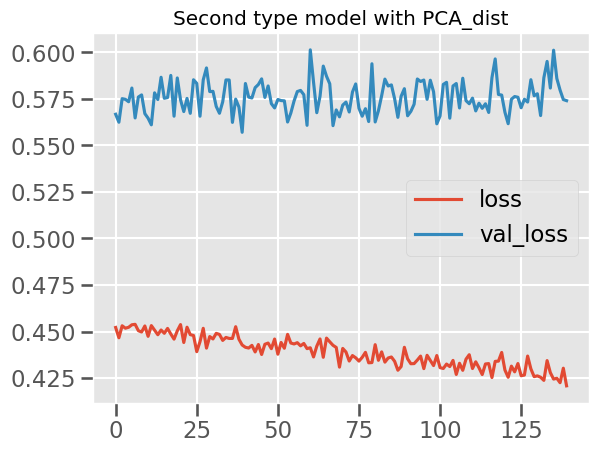

Last train loss: 0.42 and val loss: 0.57
Model fitted for --- 321.6910524368286 seconds ---


In [41]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_pca = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_pca], PI_train, epochs=200, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_pca], clean_PI_test), callbacks=[callback], verbose=0)


train_PI_prediction_second_type_pca = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_pca])
clean_PI_prediction_second_type_pca = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_pca])

plt.plot(np.array(history_pca.history["loss"][20:]))
plt.plot(np.array(history_pca.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with PCA_dist")
plt.show()

val_loss = history_pca.history["val_loss"][-1]
train_loss = history_pca.history["loss"][-1]

print(f"Last train loss: {train_loss:.2f} and val loss: {val_loss:.2f}")
print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

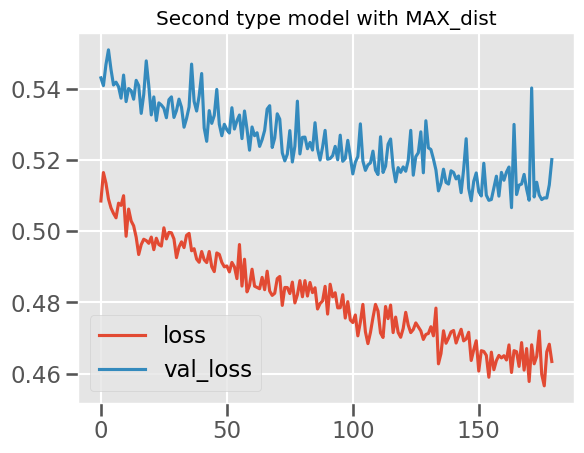

Last train loss: 0.46 and val loss: 0.52
Model fitted for --- 401.2217938899994 seconds ---


In [42]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_max = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_max], PI_train, epochs=200, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_max], clean_PI_test), callbacks=[callback], verbose=0)

train_PI_prediction_second_type_max = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_max])
clean_PI_prediction_second_type_max= model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_max])

plt.plot(np.array(history_max.history["loss"][20:]))
plt.plot(np.array(history_max.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with MAX_dist")
plt.show()


val_loss = history_max.history["val_loss"][-1]
train_loss = history_max.history["loss"][-1]

print(f"Last train loss: {train_loss:.2f} and val loss: {val_loss:.2f}")

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

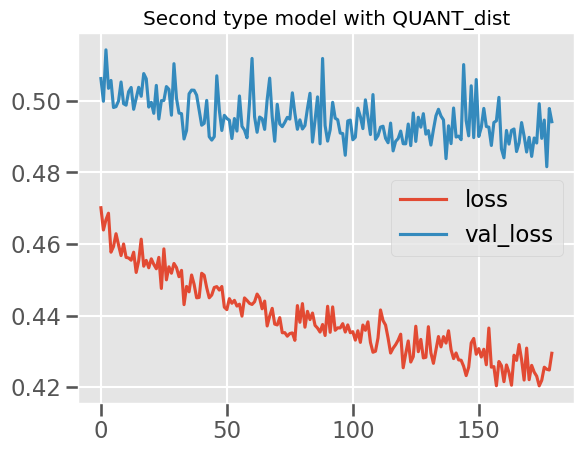

Last train loss: 0.43 and val loss: 0.49
Model fitted for --- 401.22541403770447 seconds ---


In [43]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_quant = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant], PI_train, epochs=200, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant], clean_PI_test), callbacks=[callback], verbose=0)

train_PI_prediction_second_type_quant = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant])
clean_PI_prediction_second_type_quant = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant])


plt.plot(np.array(history_quant.history["loss"][20:]))
plt.plot(np.array(history_quant.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with QUANT_dist")
plt.show()

val_loss = history_quant.history["val_loss"][-1]
train_loss = history_quant.history["loss"][-1]

print(f"Last train loss: {train_loss:.2f} and val loss: {val_loss:.2f}")

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

---
### Visualize results

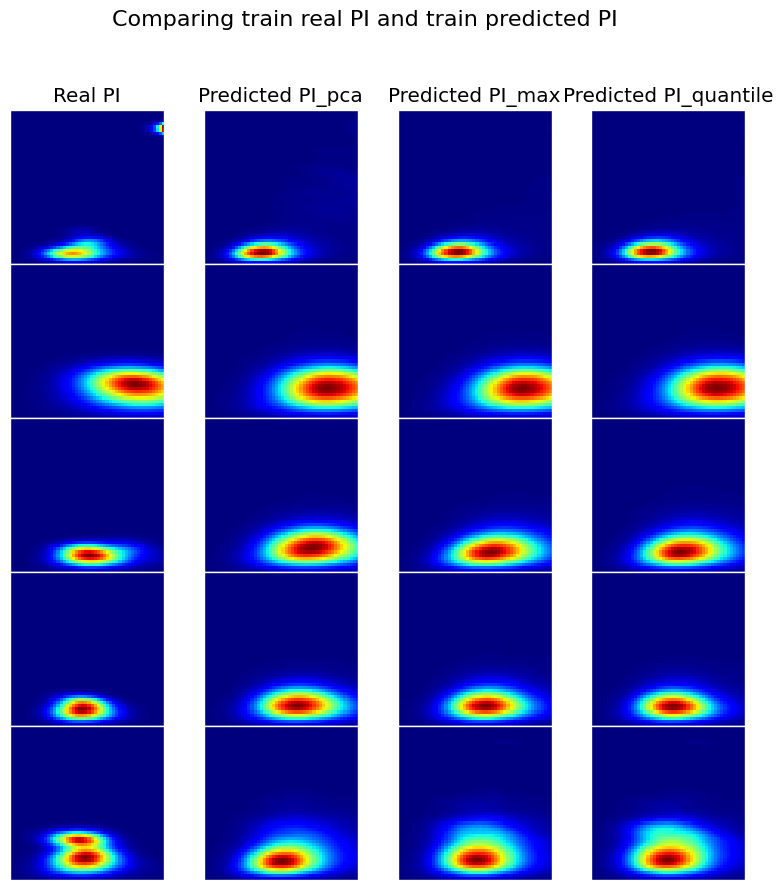

In [38]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing train real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 4, width_ratios=[1,1,1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    idx = 1000*2+35*i
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train[idx], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Real PI")
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction_second_type_pca[idx], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_pca")
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,2])
    ax.imshow(np.flip(np.reshape(train_PI_prediction_second_type_max[idx], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_max")
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,3])
    ax.imshow(np.flip(np.reshape(train_PI_prediction_second_type_quant[idx], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_quantile")
    plt.xticks([])
    plt.yticks([])

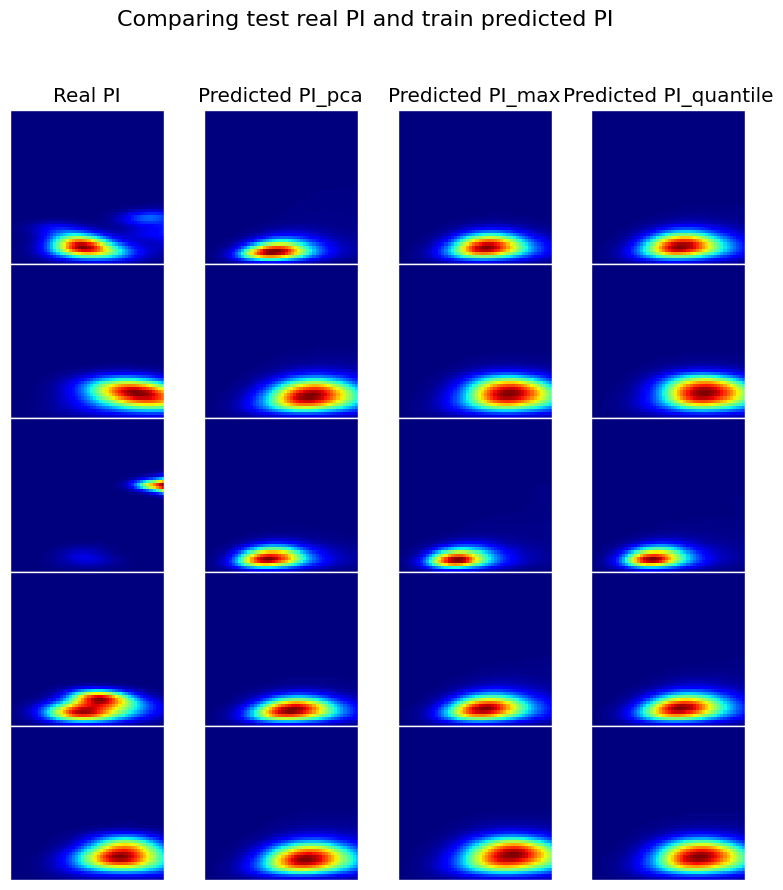

In [40]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing test real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 4, width_ratios=[1,1,1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    idx = 60*i
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(clean_PI_test[idx], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Real PI")
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type_pca[idx], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_pca")
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,2])
    ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type_max[idx], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_max")
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,3])
    ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type_quant[idx], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_quantile")
    plt.xticks([])
    plt.yticks([])

---
### Textual data

In [4]:
import pickle
# with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_text_data", "rb") as fp:   #Pickling
#     text_data = pickle.load(fp)

with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_pc_train", "rb") as fp:   #Pickling
    pc_train = pickle.load(fp)

with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_train_indexes", "rb") as fp:   #Pickling
    train_indexes = pickle.load(fp)

# with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_labels", "rb") as fp:   #Pickling
#     labels = pickle.load(fp)

with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_pds_10000_50_boostrap", 'rb') as fp:   #Pickling
    train_PD = pickle.load(fp)

with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_PI_10000_50_boostrap", 'rb') as fp:   #Pickling
    PI_train_all = pickle.load(fp)

In [5]:
pc_train[0].shape

(444, 768)

In [6]:
train_PD_1 = [[x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

train_PD_0 = [[x[0] if len(x[0])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]


PI_train = np.vstack([PI_train_all[:2000]])
clean_PI_test = np.vstack([PI_train_all[2000:2500]])

In [7]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)
features = [pca.fit_transform(cloud) for cloud in pc_train]


tf_data_train_1 = tf.ragged.constant([
    features[i] for i in train_indexes[:2000][:,0]], ragged_rank=1)
tf_data_train_2 = tf.ragged.constant([
    features[i] for i in train_indexes[:2000][:,1]], ragged_rank=1)


tf_data_test_1 = tf.ragged.constant([
    features[i] for i in train_indexes[2000:2500][:,0]], ragged_rank=1)
tf_data_test_2 = tf.ragged.constant([
    features[i] for i in train_indexes[2000:2500][:,1]], ragged_rank=1)

2025-02-14 15:55:15.465951: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 15:55:17.769615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10140 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6


---
### Calculate the distance matrix and reduce its dimensionality in three ways

In [9]:
start_time = time.time()
pdist_train = []
for idx in tqdm(train_indexes[:2000], desc = "pdist for train dataset"):
    cloud_1 = pc_train[idx[0]]
    cloud_2 = pc_train[idx[1]]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    # pdist_train.append(d)
    pdist_train.append(d[cloud_1.shape[0]:, :]) ## because all upper numbers equal to zero

pdist_test = []
for idx in tqdm(train_indexes[2000:2500], desc = "pdist for test dataset"):
    cloud_1 = pc_train[idx[0]]
    cloud_2 = pc_train[idx[1]]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    pdist_test.append(d[cloud_1.shape[0]:, :]) ## because all upper numbers equal to zero
    
print("Distance matrix calculation took --- %s seconds ---" % (time.time() - start_time))

pdist for test dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.52it/s]

Distance matrix calculation took --- 29.5206515789032 seconds ---


In [17]:
from sklearn.decomposition import PCA
n_features = 60

In [19]:
start_time = time.time()

pca = PCA(n_components=n_features)
pdist_train_reducted_pca = tf.ragged.constant([pca.fit_transform(cloud) for cloud in pdist_train], ragged_rank=1)
pdist_test_reducted_pca = tf.ragged.constant([pca.fit_transform(cloud) for cloud in pdist_test], ragged_rank=1)

print("Distance matrix reducted by PCA for --- %s seconds ---" % (time.time() - start_time))

Distance matrix reducted by PCA for --- 1991.4619612693787 seconds ---


In [28]:
start_time = time.time()


# pdist_train.partition(-n_features)
# pdist_test.partition(-n_features)

pdist_train_reducted_max = tf.ragged.constant([np.sort(cloud, axis=1)[:,-n_features:] for cloud in pdist_train], ragged_rank=1)
pdist_test_reducted_max  = tf.ragged.constant([np.sort(cloud, axis=1)[:,-n_features:] for cloud in pdist_test], ragged_rank=1)

print("Distance matrix reducted by MAX for --- %s seconds ---" % (time.time() - start_time))

Distance matrix reducted by MAX for --- 259.68254113197327 seconds ---


In [29]:
start_time = time.time()

percentiles = np.linspace(0, 100, n_features)

pdist_train_reducted_quant = tf.ragged.constant([np.percentile(cloud, percentiles, axis=-1, method = "closest_observation").transpose((1,0))
                                     for cloud in pdist_train], ragged_rank=1)
pdist_test_reducted_quant = tf.ragged.constant([np.percentile(cloud, percentiles, axis=-1, method = "closest_observation").transpose((1,0))
                                    for cloud in pdist_test], ragged_rank=1)


print("Distance matrix reducted by Quantile for --- %s seconds ---" % (time.time() - start_time))

Distance matrix reducted by Quantile for --- 263.6626009941101 seconds ---


### Training different models

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                                            patience=100, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=True)

dropout_rate = 0.2
optim = tf.keras.optimizers.Adamax(learning_rate=1e-4)
inputs_1 = tf.keras.Input(shape=(None, n_components), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None, n_components), dtype ="float32", ragged=True)
inputs_dist = tf.keras.Input(shape=(None, 60), dtype ="float32", ragged=False)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)

d = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_dist)
d = DenseRagged(units=20, use_bias=True, activation='relu')(d)
d = DenseRagged(units=10, use_bias=True, activation='relu')(d)
d = PermopRagged()(d)


z = keras.layers.Concatenate(axis=-1)([x, y, x_y, d])

# z = keras.layers.Concatenate(axis=-1)([x, y, x_y])
z = tf.keras.layers.Normalization()(z)
z = tf.keras.layers.Dense(150,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

In [34]:
def create_model_base(cloud_dim, patience = 100):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                                            patience=patience, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=True)
    
    dropout_rate = 0.2
    optim = tf.keras.optimizers.Adamax(learning_rate=1e-4)
    inputs_1 = tf.keras.Input(shape=(None, cloud_dim), dtype ="float32", ragged=True)
    inputs_2 = tf.keras.Input(shape=(None, cloud_dim), dtype ="float32", ragged=True)
    # inputs_dist = tf.keras.Input(shape=(N_points, dist_dim), dtype ="float32", ragged=False)
    
    x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
    x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
    x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
    x = PermopRagged()(x)
    
    y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
    y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
    y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
    y = PermopRagged()(y)
    
    x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
    x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
    x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
    x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
    x_y= PermopRagged()(x_y)
    
    # d = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_dist)
    # d = DenseRagged(units=20, use_bias=True, activation='relu')(d)
    # d = DenseRagged(units=10, use_bias=True, activation='relu')(d)
    # d = PermopRagged()(d)
    
    
    z = keras.layers.Concatenate(axis=-1)([x, y, x_y])
    
    # z = keras.layers.Concatenate(axis=-1)([x, y, x_y])
    z = tf.keras.layers.Normalization()(z)
    z = tf.keras.layers.Dense(150,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
    z = tf.keras.layers.Dropout(dropout_rate)(z)
    z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
    z = tf.keras.layers.Dropout(dropout_rate)(z)
    z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
    z = tf.keras.layers.Dropout(dropout_rate)(z)
    outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
    outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
    outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
    model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2], outputs=outputs)
    model_PI_second_type.compile(optimizer=optim, loss=sym_KL)
    return model_PI_second_type, callback

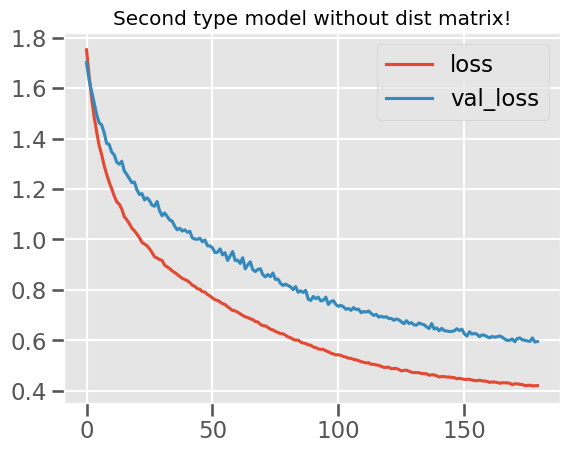

Last train loss: 0.42 and val loss: 0.60
Model fitted for --- 741.0285291671753 seconds ---


In [36]:
model_PI_second_type, callback = create_model_base(n_components, patience = 100)

history_pca = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2], PI_train, epochs=200, 
                       validation_data=([tf_data_test_1, tf_data_test_2], clean_PI_test), callbacks=[callback], verbose=0)


train_PI_prediction_second_type_pca = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2])
clean_PI_prediction_second_type_pca = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2])

plt.plot(np.array(history_pca.history["loss"][20:]))
plt.plot(np.array(history_pca.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model without dist matrix!")
plt.show()

val_loss = history_pca.history["val_loss"][-1]
train_loss = history_pca.history["loss"][-1]

print(f"Last train loss: {train_loss:.2f} and val loss: {val_loss:.2f}")
print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

2025-02-14 17:21:19.934060: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


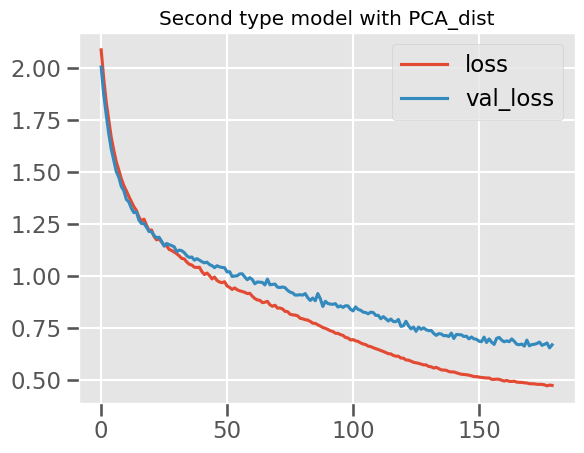

Last train loss: 0.47 and val loss: 0.67
Model fitted for --- 228.2596790790558 seconds ---


In [31]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_pca = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_pca], PI_train, epochs=200, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_pca], clean_PI_test), callbacks=[callback], verbose=0)


train_PI_prediction_second_type_pca = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_pca])
clean_PI_prediction_second_type_pca = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_pca])

plt.plot(np.array(history_pca.history["loss"][20:]))
plt.plot(np.array(history_pca.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with PCA_dist")
plt.show()

val_loss = history_pca.history["val_loss"][-1]
train_loss = history_pca.history["loss"][-1]

print(f"Last train loss: {train_loss:.2f} and val loss: {val_loss:.2f}")
print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

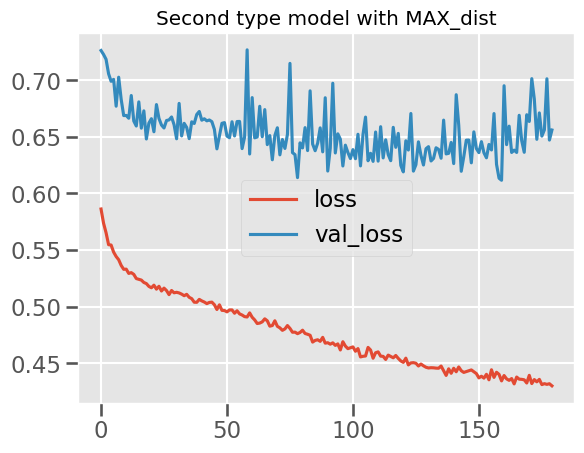

Last train loss: 0.43 and val loss: 0.66
Model fitted for --- 234.09923887252808 seconds ---


In [32]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_max = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_max], PI_train, epochs=200, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_max], clean_PI_test), callbacks=[callback], verbose=0)

train_PI_prediction_second_type_max = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_max])
clean_PI_prediction_second_type_max= model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_max])

plt.plot(np.array(history_max.history["loss"][20:]))
plt.plot(np.array(history_max.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with MAX_dist")
plt.show()


val_loss = history_max.history["val_loss"][-1]
train_loss = history_max.history["loss"][-1]

print(f"Last train loss: {train_loss:.2f} and val loss: {val_loss:.2f}")

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

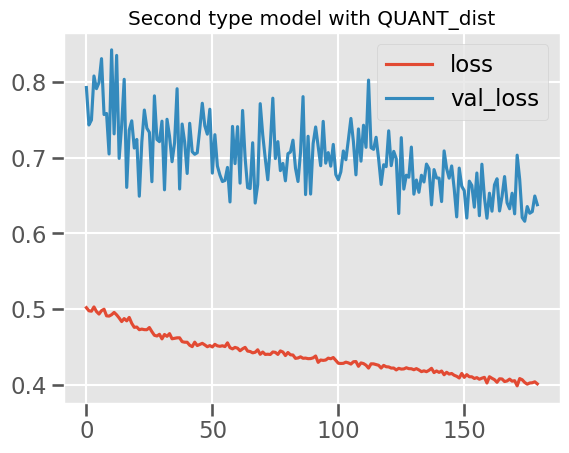

Last train loss: 0.40 and val loss: 0.64
Model fitted for --- 228.9338550567627 seconds ---


In [33]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_quant = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant], PI_train, epochs=200, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant], clean_PI_test), callbacks=[callback], verbose=0)

train_PI_prediction_second_type_quant = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant])
clean_PI_prediction_second_type_quant = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant])


plt.plot(np.array(history_quant.history["loss"][20:]))
plt.plot(np.array(history_quant.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with QUANT_dist")
plt.show()

val_loss = history_quant.history["val_loss"][-1]
train_loss = history_quant.history["loss"][-1]

print(f"Last train loss: {train_loss:.2f} and val loss: {val_loss:.2f}")

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))